Here we used RandomForest to classify the passengers to see if they survived or perished based on the available features. This helped us understand which features  were important for survival

In [112]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import validation_curve

Load the data, split it into features and targets and make dummy variables for RF

In [113]:
# Read in the data
data = pd.read_csv('titanic_data.csv')

# Define independent and dependent variables
X = data.drop('Survived', axis=1)
y = data['Survived']

# Ensure categorical variables are encoded correctly
X = pd.get_dummies(X, drop_first=True)

Used random oversampling to deal with the uneven classes

In [114]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply random oversampling to the training data
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)


/Users/motegui/Documents/GitHub/DBM2/myenv/lib/python3.13/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/motegui/Documents/GitHub/DBM2/myenv/lib/python3.13/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Use cross validation to find the best parameters to use for Random forest

In [115]:
param_grid = {
    'n_estimators': [150, 200],
    'max_depth': [12, 14, 16],
    'min_samples_split': [8, 10, 12],
    'min_samples_leaf': [4, 5, 6]
}


rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

best_model = grid_search.best_estimator_


This script plots a validation curve to analyze the effect of the `max_depth` hyperparameter 
 on a Random Forest model. It uses 3-fold cross-validation to compute training and validation 
 accuracy for `max_depth` values from 1 to 50. The plot highlights mean accuracy and standard 
 deviation to identify the optimal `max_depth` while balancing overfitting and underfitting.


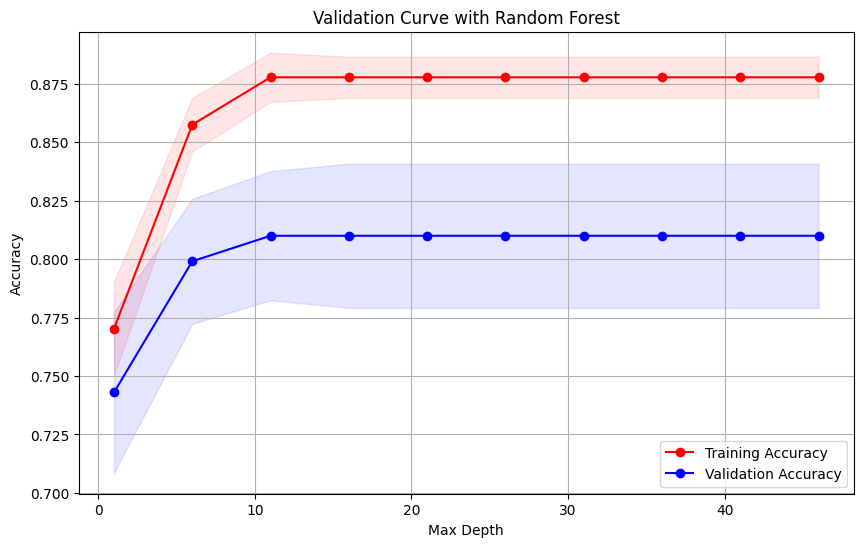

In [116]:
param_range = np.arange(1, 50, 5) 

train_scores, test_scores = validation_curve(
    best_model,
    X_train_resampled,
    y_train_resampled,
    param_name="max_depth", 
    param_range=param_range,
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(param_range, train_scores_mean, label="Training Accuracy", color="r", marker='o')
plt.plot(param_range, test_scores_mean, label="Validation Accuracy", color="b", marker='o')
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="b")
plt.title("Validation Curve with Random Forest")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()


Use the best model for prediction

In [117]:
# Predictions and evaluation
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=["Perished", "Survived"])
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=["Perished", "Survived"],
    columns=["Perished", "Survived"]
)


Plot the feature importance

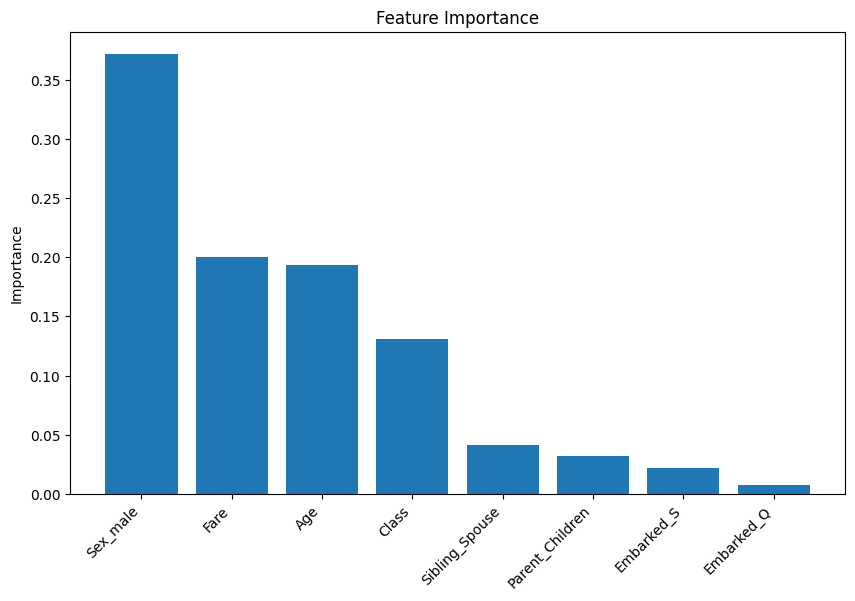

In [118]:
importances = best_model.feature_importances_
features = X.columns
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance')
plt.ylabel('Importance')
plt.show()

Show the accuracy, classification report and confusion matrix

Best set of hyperparameters: {'max_depth': 14, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Model accuracy: 0.8162393162393162
Classification Report:
               precision    recall  f1-score   support

    Perished       0.83      0.87      0.85       137
    Survived       0.80      0.74      0.77        97

    accuracy                           0.82       234
   macro avg       0.81      0.81      0.81       234
weighted avg       0.82      0.82      0.82       234



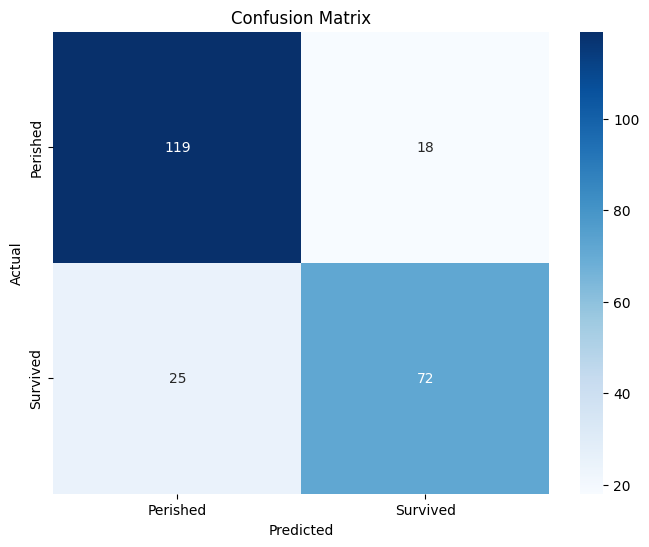

In [119]:
print(f"Best set of hyperparameters: {grid_search.best_params_}")
print(f"Model accuracy: {accuracy}")
print("Classification Report:\n", report)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Show the ROC curve of the model

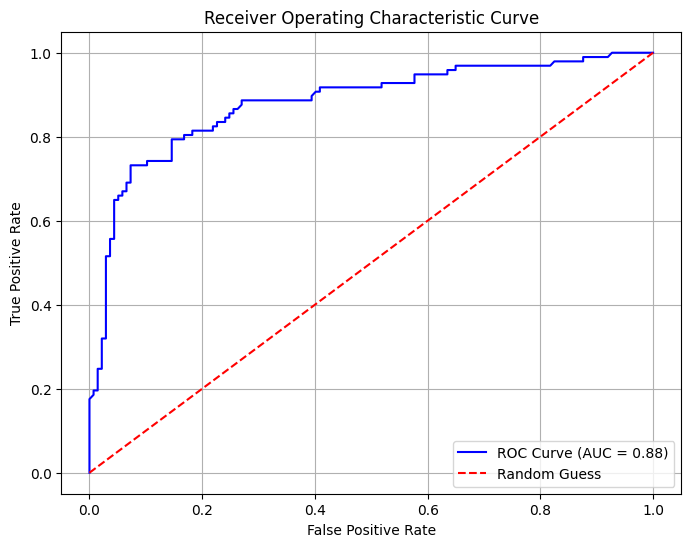

In [120]:
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()